In [1]:
import os
import time
import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Generate model that returns the prediction

Note that while training the model, I have only trained it on the dataset provided without applying any data augmentation techniques. Training accuracy obtained was ~63%

In [2]:
# helper method to define model
def deepnn(x):
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    # Conv Layer 1
    W_conv1 = tf.get_variable("weight_1", shape=[5, 5, 1, 6], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv1 = tf.get_variable("bias_1", shape=[6], initializer=tf.constant_initializer(0.1))
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Max Pooling Layer 1
    h_pool1 = max_pool_2x2(h_conv1)

    # Conv Layer 2
    W_conv2 = tf.get_variable("weight_2", shape=[5, 5, 6, 16], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv2 = tf.get_variable("bias_2", shape=[16], initializer=tf.constant_initializer(0.1))
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # Max Pooling Layer 2
    h_pool2 = max_pool_2x2(h_conv2)

    h_pool_flatten = tf.reshape(h_pool2, (-1, 7*7*16))

    # Fully Connected 1
    W_fc1 = tf.get_variable("weight_3", shape=[7*7*16, 120], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_fc1 = tf.get_variable("bias_3", shape=[120], initializer=tf.constant_initializer(0.1))
    h_fc1 = tf.matmul(h_pool_flatten, W_fc1) + b_fc1
    
    # Fully connected 2
    W_fc2 = tf.get_variable("weight_4", shape=[120, 10], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_fc2 = tf.get_variable("bias_4", shape=[10],initializer=tf.constant_initializer(0.1))
    logits = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    y_conv = tf.nn.softmax(logits, name='y_conv')
    
    return y_conv, logits

# Helper functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape, i):
    return tf.get_variable("weight", shape=shape, initializer=tf.truncated_normal_initializer(stddev=0.1))


def bias_variable(shape, i):
    return tf.get_variable("bias", shape=shape, initializer=tf.constant_initializer(0.1))

In [3]:
# create Dummy class 
class Dummy():
    pass

env = Dummy()

In [4]:
def cw(model, x, y=None, eps=1.0, ord_=2, T=2, optimizer=tf.train.AdamOptimizer(learning_rate=0.1), alpha=0.9, min_prob=0, clip=[0.0, 1.0]):
    
    xshape = x.get_shape().as_list()
    noise = tf.get_variable('noise', xshape, tf.float32, initializer=tf.initializers.zeros)
    
    clip[0] = 0.0
    clip[1] = 1.0
    
    x_scaled = (x - clip[0]) / (clip[1] - clip[0])
    
    z = tf.clip_by_value(x_scaled, 1e-8, 1 - 1e-8)
    xinv = tf.log(z / (1-z)) / T;
    
    xadv = tf.sigmoid(T * (xinv + noise))
    xadv = xadv * (clip[1] - clip[0]) + clip[0]
    
    ybar, logits = model(xadv)
    ydim = ybar.get_shape().as_list()[1]
    
    if y is not None:
        y = tf.cond(tf.equal(tf.rank(y), 0), 
                   lambda: tf.fill([xshape[0]], y),
                   lambda: tf.identity(y))
    else:
        y = tf.argmin(ybar, axis=1, output_type=tf.int32)
        
    mask = tf.one_hot(y, ydim, on_value=0.0, off_value=float('inf'))
    yt = tf.reduce_max(logits-mask, axis=1)
    yo = tf.reduce_max(logits, axis=1)
    
    loss0 = tf.nn.relu(yo - yt + min_prob)
    
    axis = list(range(1, len(xshape)))
    ord_ = float(ord_)
    
    tau0 = tf.fill([xshape[0]] + [1]*len(axis), clip[1])
    tau = tf.get_variable('cw8-noise-upperbound', dtype=tf.float32, initializer=tau0, trainable=False)
    if 2 == ord_:
        loss1 = tf.reduce_sum(tf.square(xadv-x), axis=axis)
    else:
        tau0 = tf.fill([xshape[0]] + [1]*len(axis), clip[1])
        tau = tf.get_variable('cw8-noise-upperbound', dtype=tf.float32, initializer=tau0, trainable=False)
        
        diff = xadv - x - tau
        
        tau = alpha * tf.to_float(tf.reduce_all(diff < 0, axis=axis))
        loss1 = tf.nn.relu(tf.reduce_sum(diff, axis=axis))
        
    loss = eps * loss0 + loss1
    train_op = optimizer.minimize(loss, var_list=[noise])
    
    if 2 != ord:
        train_op = tf.group(train_op, tau)
        
    return train_op, xadv, noise

In [5]:
# defining environment in which the model is set

with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
    env.x = tf.placeholder(tf.float32, (None, 28, 28, 1),
                           name='x')
    env.y = tf.placeholder(tf.float32, (None, 10), name='y')
    env.ybar, logits = deepnn(env.x)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=logits)
        env.loss = tf.reduce_mean(xent, name='loss')     
    
    optimizer = tf.train.AdamOptimizer()
    vs = tf.global_variables()
    env.train_op = optimizer.minimize(env.loss, var_list = vs)

    env.saver = tf.train.Saver(tf.global_variables()[:8])

    env.x_fixed = tf.placeholder(tf.float32, (1, 28, 28, 1), name='x_fixed')
    env.adv_eps = tf.placeholder(tf.float32, (), name='adv_eps')
    env.adv_y = tf.placeholder(tf.int32, (), name='adv_y')
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
    env.adv_train_op, env.xadv, env.noise = cw(deepnn, env.x_fixed, y = env.adv_y, eps=env.adv_eps, optimizer=optimizer)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [6]:
sess = tf.InteractiveSession()

In [7]:
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [8]:
# Load trained model

env.saver.restore(sess, './mnist_model/model_chkpt-9990')

INFO:tensorflow:Restoring parameters from ./mnist_model/model_chkpt-9990


In [9]:
def make_cw(env, X_data, y, epochs=1, eps=0.1, batch_size=1):
    
    X_adv = np.empty_like(X_data)
    
    feed_dict = {
        env.x_fixed: X_data,
        env.adv_eps: eps,
        env.adv_y: y
    }
    
    sess.run(env.noise.initializer)
    
    for epoch in range(epochs):
        sess.run(env.adv_train_op, feed_dict=feed_dict)
        
    xadv = sess.run(env.xadv, feed_dict=feed_dict)
    X_adv = xadv
    
    return X_adv

In [10]:
def cw_binary_search(env, image, target, epochs=1, bound=(1e-8, 1e2),
                     binary_epochs=10):
    """
    Search for the best result on one image sample.
    """
    print('\nMaking adversarials via CW')

    mindist = float('inf')
    advimg, advprob = None, -1

    lo, hi = bound
    for epoch in range(binary_epochs):
        eps = lo + (hi - lo) / 2

        feed_dict = {
            env.x_fixed: image,
            env.adv_eps: eps,
            env.adv_y: target}

        # reset the noise before every iteration
        sess.run(env.noise.initializer)
        for epoch in range(epochs):
            sess.run(env.adv_train_op, feed_dict=feed_dict)

        xadv = sess.run(env.xadv, feed_dict=feed_dict)
        ybar = predict(sess, env, xadv, 1)
        label, prob = np.argmax(ybar), np.max(ybar)

        if label != target:
            lo = eps
            if lo > bound[1]:
                eps *= 10
        else:
            dist = np.linalg.norm(xadv.flatten()-image.flatten())
            if mindist < 0 or dist < mindist:
                mindist = dist
                advimg = xadv
                advprob = prob
            hi = eps

    print('Min distance: {:g}'.format(mindist))
    return advimg, advprob

In [11]:
def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    y_batch = sess.run(env.ybar, feed_dict={env.x: X_data})
    yval = y_batch
    print()
    return yval

##### The following three cells are an alternate way to load the data 

In [12]:
# filename = './cifar/tfrecords/eval.tfrecords/'
# record_iterator = tf.python_io.tf_record_iterator(filename)
# serialized_img_example = next(record_iterator)

In [13]:
# serialized_img_example = next(record_iterator)

In [14]:
# example = tf.train.Example()
# example.ParseFromString(serialized_img_example)
# image = example.features.feature['image'].bytes_list.value
# label = example.features.feature['label'].int64_list.value[0]

### Loading data from pickle file directly

In [12]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [57]:
test_x = mnist.test.images.reshape(-1, 784)[2]
test_y = mnist.test.labels.reshape(-1, 10)[2]

new_img = test_x.reshape((28, 28, 1))

In [58]:
import matplotlib.pyplot as plt

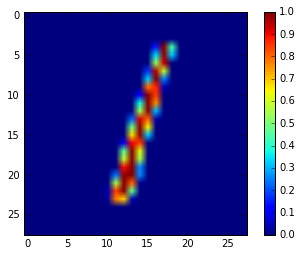

In [59]:
# plt.imshow(new_img.reshape((28, 28)))
# plt.savefig('./cifar_adv/cw/actual_1.png')

fig, ax = plt.subplots()

im = ax.imshow(new_img.reshape((28, 28)), cmap='jet')

fig.colorbar(im, ax=ax)

plt.savefig('./mnist_adv/1/original.png')

In [60]:
test_y

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [61]:
# Adding an extra dimension

img = np.expand_dims(new_img, axis=0)

In [62]:
img.shape

(1, 28, 28, 1)

In [63]:
# Predicting output on original image

op = predict(sess, env, img)


Predicting
()


In [64]:
print(op)
np.argmax(op, axis=1)

[[8.1773687e-06 9.9833614e-01 1.1982935e-04 6.2001659e-06 6.3188007e-04
  3.4542013e-06 3.7821941e-05 8.1796857e-04 3.2607415e-05 5.9832505e-06]]


array([1])

In [65]:
# Generating adversarial image

# X_adv = make_cw(env, img, 0, eps=1, epochs=2)
xadv, yadv = cw_binary_search(env, img, target=0, epochs=100, binary_epochs=10)


Making adversarials via CW

Predicting
()

Predicting
()

Predicting
()

Predicting
()

Predicting
()

Predicting
()

Predicting
()

Predicting
()

Predicting
()

Predicting
()
Min distance: 4.86176


In [66]:
yadv

0.20874657

In [67]:
# Getting output prediction on the advrsarial image

adv_op = predict(sess, env, xadv)


Predicting
()


In [68]:
print(adv_op)
np.argmax(adv_op)

[[0.20874657 0.19806553 0.19398104 0.02868816 0.0015856  0.19743533
  0.08043781 0.00574932 0.0622862  0.02302445]]


0

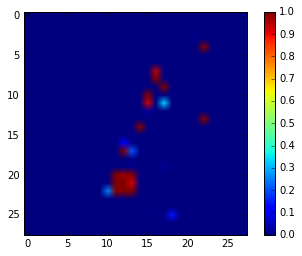

In [69]:
# plt.imshow(xadv.reshape(28, 28))
# plt.savefig('./cifar_adv/cw/actual_1_adv_3.png')

fig, ax = plt.subplots()

im = ax.imshow(xadv.reshape((28, 28)), cmap='jet')

fig.colorbar(im, ax=ax)

plt.savefig('./mnist_adv/1/cw.png')

In [70]:
diff_img = xadv - img

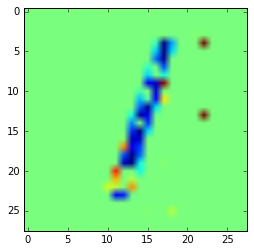

In [71]:
plt.imshow(diff_img.reshape(28, 28))
# plt.savefig('./cifar_adv/cw/diff_1_3.png')